## DocAssistant App



<a></a>

## Installing the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as ply
import plotly.graph_objs as go
import seaborn as sns
from sklearn.metrics import accuracy_score
import warnings
from collections import Counter
from pandas import json_normalize
from scipy.sparse import csr_matrix
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import (StratifiedKFold, GridSearchCV, train_test_split,
                                     cross_val_predict)
ply.init_notebook_mode(connected=True)
%matplotlib inline

## Data Preparation

THe data is taken from drugs.com which is a comprehensive database of prescriptions. We will load the JSONL file and preprocess the data. Since the data is quite large, we will load it in chunks to avoid memory issues. Jsonl files are line-delimited JSON objects. We need special methods to read JSONL files in chunks.

In [3]:
unfiltered_data = pd.read_json('roam_prescription_based_prediction.jsonl', lines=True)

In [4]:
# Filter out rows for providers with <40 unique prescribed drugs. Then, remove providers that
# correspond to specialties with <40 providers in the filtered dataset.
data = unfiltered_data[unfiltered_data.cms_prescription_counts.apply(lambda x: len(x.keys())) >= 40]
specialty_counts = Counter(data.provider_variables.apply(lambda x: x['specialty']))
specialties_to_ignore = set(
    specialty for specialty, _ in filter(lambda x: x[1] < 40, specialty_counts.items()))
data = data[data.provider_variables.apply(lambda x: x['specialty'] not in specialties_to_ignore)]
data.head()

,cms_prescription_counts,provider_variables,npi
0,"{'DOXAZOSIN MESYLATE': 26, 'MIDODRINE HCL': 12...","{'settlement_type': 'non-urban', 'generic_rx_c...",1295763035
4,"{'PIOGLITAZONE HCL': 24, 'BENAZEPRIL HCL': 29,...","{'settlement_type': 'non-urban', 'generic_rx_c...",1437366804
8,"{'CARAFATE': 16, 'CARBIDOPA-LEVODOPA': 29, 'PR...","{'settlement_type': 'urban', 'generic_rx_count...",1316196462
16,"{'CLONAZEPAM': 256, 'TRIHEXYPHENIDYL HCL': 21,...","{'settlement_type': 'urban', 'generic_rx_count...",1215979554
19,"{'DESIPRAMINE HCL': 26, 'RISPERIDONE': 108, 'C...","{'settlement_type': 'urban', 'generic_rx_count...",1174564165


In [5]:
# Expand the provider variables into a data frame.
provider_variables = json_normalize(data=data.provider_variables)
data.drop('provider_variables', axis=1, inplace=True)
provider_variables.head()

,settlement_type,generic_rx_count,specialty,years_practicing,gender,region,brand_name_rx_count
0,non-urban,2287,Nephrology,7,M,South,384
1,non-urban,1035,Nephrology,6,M,West,316
2,urban,2452,Gastroenterology,5,M,Northeast,374
3,urban,3462,Psychiatry,7,M,Midwest,683
4,urban,2300,Psychiatry,7,M,Northeast,143


In [6]:
# Transform prescription count column into sparse matrix.
vectorizer = DictVectorizer(sparse=True)
X = vectorizer.fit_transform(data.cms_prescription_counts)

## Exploratory Analysis

There are 29 unique classes across the response and the distribution is highly imbalanced as mentioned previously. Cardiovascular Disease accounts for nearly 20% of all of the samples, while the 12 lowest frequency classes account for fewer than 1% each. This will be important to keep in mind later to ensure that the model doesn't bias too heavily towards the high frequency classes.

In [7]:
# Generate the class distribution.
provider_variables.specialty.unique().shape[0]

33

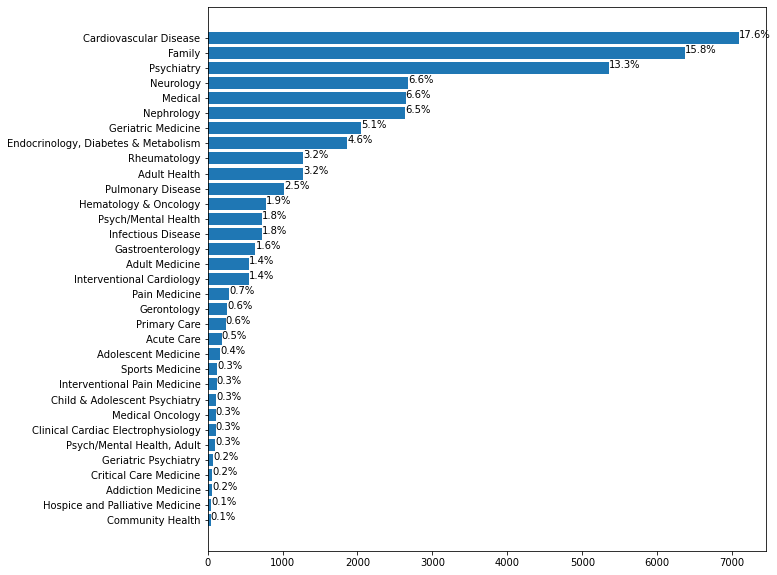

In [8]:
# Generating the class distribution in bar chart.
plt.figure(figsize=(10,10))
counts = pd.Series(provider_variables.specialty).value_counts()[::-1] 
plt.barh(counts.index, counts.values)
for i, v in enumerate(counts.values):
    plt.text(v, i, '{:.1f}%'.format(100 * v / provider_variables.specialty.shape[0]))

Also, it appears that there are some very similar classes that could be tricky for the model to distinguish. For example, Child & Adolescent Psychiatry versus Psychiatry, and Geriatric Medicine versus Gerontology. We'll use PCA to explore these relationships further as well as get an idea of the expected separation between classes.

In [9]:
# Sum the counts across all providers for each specialty and normalize.
counts_per_specialty = pd.DataFrame(
    X.todense(), index=provider_variables.specialty
).groupby(
    'specialty'
).sum()
dist_per_specialty = counts_per_specialty.values / \
    counts_per_specialty.values.sum(axis=1).reshape((-1, 1))

In [10]:
# Fit PCA and keep only 2 dimensions for plotting.
pca = PCA(n_components=2)
specialties_pca = pca.fit_transform(dist_per_specialty)

In [11]:
# Plot the first two principal components.
scatter = go.Scattergl(
    x=specialties_pca[:,0],
    y=specialties_pca[:,1],
    mode='markers',
    text=counts_per_specialty.index,
    hoverinfo='text',
    marker=dict(
        opacity=0.5
    )
)
layout = go.Layout(
    title='Decomposition of Empirical Drug Distributions',
    xaxis=dict(
        title='PC1'
    ),
    yaxis=dict(
        title='PC2'
    ),
    hovermode='closest'
)
figure = go.Figure(data=[scatter], layout=layout)
ply.iplot(figure)

Text(0.5, 1.0, 'Drug Frequency Distribution (top 500)')

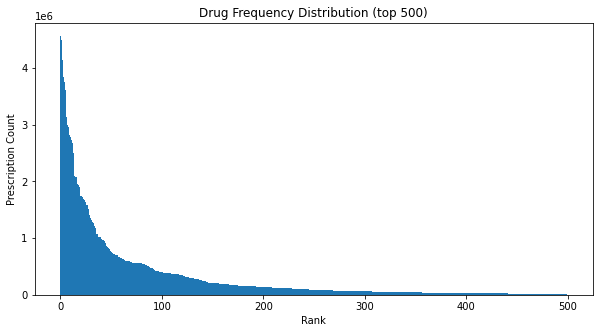

In [12]:
top_n = 500
values = np.array(X.sum(axis=0))[0]
sort_order = np.argsort(values)[::-1][:top_n]
plt.figure(figsize=(10,5))
plt.bar(range(top_n), values[sort_order], width=1)
plt.xlabel('Rank')
plt.ylabel('Prescription Count')
plt.title('Drug Frequency Distribution (top {})'.format(top_n))

In [13]:
top_n_drugs = 15
top_drugs_df = pd.DataFrame({
    'Drug Name': np.array(vectorizer.feature_names_)[sort_order[:top_n_drugs]],
    'Count': list(map(int, values[sort_order[:top_n_drugs]]))
})
top_drugs_df['Proportion of All Prescriptions'] = top_drugs_df['Count'] / values.sum()
top_drugs_df['Cumulative Proportion of All Prescriptions'] = \
    top_drugs_df['Proportion of All Prescriptions'].cumsum()
top_drugs_df

,Drug Name,Count,Proportion of All Prescriptions,Cumulative Proportion of All Prescriptions
0,LISINOPRIL,4563509,0.027283,0.027283
1,AMLODIPINE BESYLATE,4494231,0.026869,0.054152
2,SIMVASTATIN,4144629,0.024779,0.078931
3,FUROSEMIDE,3834944,0.022927,0.101858
4,ATORVASTATIN CALCIUM,3750135,0.022420,0.124278
5,LEVOTHYROXINE SODIUM,3613821,0.021605,0.145883
6,METOPROLOL TARTRATE,3136307,0.018750,0.164634
7,HYDROCODONE-ACETAMINOPHEN,2985613,0.017850,0.182483
8,OMEPRAZOLE,2966475,0.017735,0.200218
9,CLOPIDOGREL,2809993,0.016800,0.217018


Next, we will look at correlation between the drug features. Given that we have generics and brand name drugs in this dataset, we expect there to be some correlation.

There appear to be several drugs prescribed by only one provider in the dataset which causes perfect correlation between some features. Looking at the distribution of unique providers for each drug, we see that there are quite a few drugs that have a limited number of providers. We may want to remove some of these as predictors.

Looking at the correlated pairs excluding drugs prescribed by only one provider, we see a lot of HIV drugs.

In [14]:
drug_correlations = np.corrcoef(X.todense(), rowvar=False)
np.fill_diagonal(drug_correlations, 0)
drug_correlations = np.triu(drug_correlations)

<Axes: title={'center': 'Drugs by Number of Unique Providers (clipped at 50)'}, ylabel='Frequency'>

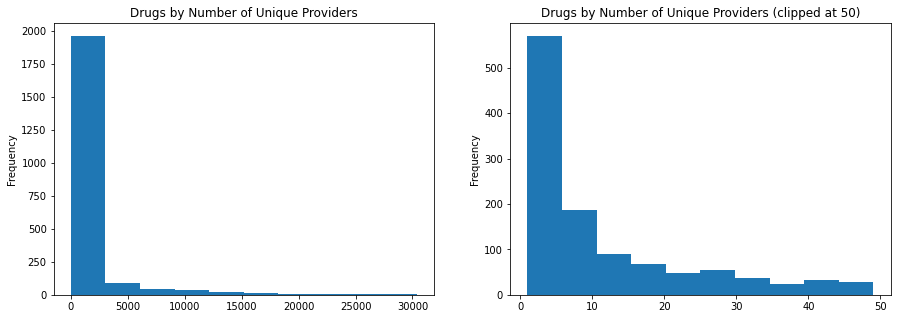

In [16]:
unique_provider_counts = np.array((X > 0).sum(axis=0))[0]
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
pd.Series(unique_provider_counts).plot(
    kind='hist', title='Drugs by Number of Unique Providers')
plt.subplot(1, 2, 2)
clip_at = 50
pd.Series(list(filter(lambda x: x < clip_at, unique_provider_counts))).plot(
    kind='hist', title='Drugs by Number of Unique Providers (clipped at {})'.format(clip_at))

In [15]:
correlated_pairs = zip(*(drug_correlations > .85).nonzero())
pd.DataFrame(
    sorted([
        (vectorizer.feature_names_[i], vectorizer.feature_names_[j], drug_correlations[i, j],
         unique_provider_counts[i], unique_provider_counts[j])
        for i, j in correlated_pairs
        if unique_provider_counts[i] > 1 and unique_provider_counts[j] > 1],
        key=lambda x: x[2], reverse=True),
    columns=['Drug 1', 'Drug 2', 'Correlation', 'Drug 1 Provider Count', 'Drug 2 Provider Count']
)

NameError: name 'unique_provider_counts' is not defined

When looking at word counts in a natural language corpus, a similar power law pattern to the one seen above in the drug frequency emerges. A common exploratory technique used in the analysis of language is topic modelling, which refers to the unsupervised identification of topics, or groups of related words, in text. Latent Dirichlet Allocation (LDA) is one such model.

In this dataset, we can think of each provider as a document and each drug that that provider prescribes as a word in the document. Using this analogy, we can apply LDA to identify groups of related drugs. LDA also gives vector representations for documents which lets us use it for dimensionality reduction purposes as well. This type of analysis can help denoise the features we send into a predictive model (especially when it comes to brand name drugs versus generics).

LDA requires setting a number of topics a priori, and it's a bit of an art to find the best value. We fix it at 50, but it could be interesting to experiment with this number further.

In [17]:
# Fit LDA model fixing k at 50.
lda = LatentDirichletAllocation(n_components=50, random_state=523)
lda.fit(X)

LatentDirichletAllocation(n_components=50, random_state=523)

In [18]:
p_w = np.array(X.sum(axis=0))[0] / X.sum()

def relevance(phi_kw, lambda_=.6):
    """Given a topic vector (probability of each drug given the topic) return a
    relevance score vector."""
    return lambda_ * np.log(phi_kw) + (1 - lambda_) * np.log (phi_kw / p_w)

In [19]:
# Extract the distribution over drugs for each topic, apply the relevance weighting above,
# and show the top N drugs for each topic.
def lda_summary_df(lda, top_n_drugs=3, **kwargs):
    topic_term_distribution = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
    rows = []
    for i in range(lda.n_components):
        top_term_indices = np.argsort(
            relevance(topic_term_distribution[i], **kwargs))[::-1][:top_n_drugs]
        rows.append(np.array(vectorizer.feature_names_)[top_term_indices])
    top_drugs_per_topic = pd.DataFrame(rows)
    top_drugs_per_topic.index = map(lambda x: 'Topic {}'.format(x), range(lda.n_components))
    top_drugs_per_topic.columns = map(lambda x: 'Drug #{}'.format(x+1), range(top_n_drugs))
    return top_drugs_per_topic

Inspecting the learned topics from LDA, we see patterns of related drugs emerging. For example:

* Topic 4 (TEMAZEPAM, LORAZEPAM, CLONAZEPAM): Sedatives.
* Topic 7 (COPAXONE, BACLOFEN, AVONEX): MS.
* Topic 10 (NORVIR, TRUVADA, ISENTRESS): HIV medications.
* Topic 13 (MORPHINE SULFATE ER, OXYCODONE HCL, OXYCODONE HCL-ACETAMINOPHEN): Opiate pain relievers.
* Topic 28 (JANUMET, TRADJENTA, JANUVIA): Diabetes.
* Topic 47 (LEVETIRACETAM, VIMPAT, LAMOTRIGINE): Used to treat seizures.

In [20]:
lda_summary = lda_summary_df(lda)
lda_summary

,Drug #1,Drug #2,Drug #3
Topic 0,LEVOTHYROXINE SODIUM,LANTUS,HUMALOG
Topic 1,OXYCODONE HCL,MORPHINE SULFATE ER,HYDROCODONE-ACETAMINOPHEN
Topic 2,CLONAZEPAM,ALPRAZOLAM,TRAZODONE HCL
Topic 3,NORVIR,TRUVADA,ISENTRESS
Topic 4,WARFARIN SODIUM,IPRATROPIUM-ALBUTEROL,FUROSEMIDE
Topic 5,JANTOVEN,NAMENDA,FUROSEMIDE
Topic 6,LEVETIRACETAM,VIMPAT,ZONISAMIDE
Topic 7,LANTUS SOLOSTAR,BD ULTRA-FINE PEN NEEDLE,LEVEMIR FLEXPEN
Topic 8,QUETIAPINE FUMARATE,LATANOPROST,MIRTAZAPINE
Topic 9,HYDROCODONE-ACETAMINOPHEN,ALPRAZOLAM,CARISOPRODOL


In [21]:
# Show the most prevalent topics found in the dataset measured by the mean probability
# assigned to that topic across all rows.
provider_topic_matrix = lda.transform(X)
topic_prevalence = provider_topic_matrix.mean(axis=0)
topic_order = np.argsort(topic_prevalence)[::-1]
lda_topic_prevalence = pd.DataFrame(
    dict(Topic=topic_order, Prevalence=topic_prevalence[topic_order]))
lda_topic_prevalence['Top 3 Drugs from Topic'] = \
    lda_topic_prevalence.Topic.apply(lambda x: ', '.join(lda_summary.iloc[x]))
lda_topic_prevalence

,Topic,Prevalence,Top 3 Drugs from Topic
0,19,0.076906,"CARVEDILOL, LISINOPRIL, METOPROLOL TARTRATE"
1,2,0.076581,"CLONAZEPAM, ALPRAZOLAM, TRAZODONE HCL"
2,29,0.073068,"BENZTROPINE MESYLATE, RISPERIDONE, OLANZAPINE"
3,44,0.053888,"LISINOPRIL, OMEPRAZOLE, SIMVASTATIN"
4,23,0.037599,"CLOPIDOGREL, ISOSORBIDE MONONITRATE ER, RANEXA"
5,42,0.033962,"CARBIDOPA-LEVODOPA, PRIMIDONE, GABAPENTIN"
6,18,0.032945,"ATORVASTATIN CALCIUM, SIMVASTATIN, METOPROLOL ..."
7,15,0.032801,"PROAIR HFA, LISINOPRIL, RANITIDINE HCL"
8,38,0.029367,"RENVELA, SENSIPAR, CALCIUM ACETATE"
9,47,0.026996,"RAMIPRIL, CRESTOR, ATORVASTATIN CALCIUM"


## Predicting Provider Specialty

Next, we'll start building some classification models. Through error analysis and careful interpretation of metrics, we'll keep a close eye on the problem of imbalanced classes.

The F1 score is a standard metric for evaluating classification models, and there are a few ways to generalize this metric to the multiclass case. We will primarily use the macro averaging strategy which refers to averaging the F1 score computed individually for each class. Note that this means that classes are weighted equally in the scoring metric despite their widely varying sizes. The micro averaging strategy refers to summing up TP, FP, etc counts across all the classes and computing F1 using those numbers.

Because there are some low count classes, it is possible that some of the trained models will not produce any predictions for a given class. In this case, precision is undefined for that class which in turn means that the macro F1 is undefined. In these cases, the default behavior is to fill with a score of 0. Lots of warnings are thrown when this happens, but since this is expected, we'll turn them off.

In [22]:
warnings.filterwarnings(
    "ignore", category=sklearn.exceptions.UndefinedMetricWarning)

NameError: name 'sklearn' is not defined

Finally, we split the data into a training set and a test set which will be used to evaluate errors. We'll also use a stratified 3-fold cross validation on the training set to tune hyperparameters, obtain estimates of test metrics, and perform error analysis. We initialize the splitter class below to be able to use the same folds across the various models explored.

In [23]:
X_train, X_test, X_train_lda, X_test_lda, provider_variables_train, provider_variables_test =\
    train_test_split(X, lda.transform(X), provider_variables,
                     stratify=provider_variables.specialty, test_size=.25)

In [24]:
splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=237)

### Logistic Regression

We look at a couple different ways of applying logistic regression. The first is to use a TFIDF transform on the drug counts before feeding the transformed result into the model as features. This is a standard practice in NLP and is used to better highlight the drugs that are prescribed unusually often by a given provider. The second is to use the low dimensional vector representations generated by LDA as features. These vectors can be interpreted as distributions over the latent topics, so this essentially turns our feature space from individual drugs into higher level groups such as sedatives, HIV meds, diabetes meds, etc.

In [25]:
class_labels = provider_variables_train.specialty.value_counts()

def fit_lr_model(X, y, max_iter=100, param_grid={'C': np.logspace(0, 10, 10)}):
    """Fit a logistic regression model and obtain cross validated predictions
    for error analysis."""

    # Fit model.
    model = GridSearchCV(
        LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',
            max_iter=max_iter
        ),
        scoring=['f1_macro', 'f1_micro'],
        param_grid=param_grid,
        cv=splitter,
        return_train_score=True,
        refit='f1_macro'
    )
    model.fit(X, y)
    
    # Obtain cross validated predictions.
    cv_preds = cross_val_predict(model.best_estimator_, X, y, cv=splitter)
    
    # Summarize F1 score on the cross validated predictions.
    f1_scores = f1_score(y, cv_preds, labels=class_labels.index, average=None)
    class_summary = pd.DataFrame(
        list(zip(class_labels.index, f1_scores, class_labels.values, np.argsort(-f1_scores).argsort() + 1)),
        columns=['Specialty', 'F1', 'True Count', 'F1 Rank']
    )
    
    # Confusion matrix on cross validated predictions.
    confusion_matrix_cv_preds = pd.DataFrame(
        confusion_matrix(y, cv_preds, labels=class_labels.index))
    confusion_matrix_cv_preds.index = class_labels.index
    confusion_matrix_cv_preds.columns = class_labels.index
    return model, cv_preds, class_summary, confusion_matrix_cv_preds

#### TFIDF Features

In [26]:
# Obtain a TFIDF transform and apply to both the train and test sets.
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train)
X_train_tfidf = tfidf_transformer.transform(X_train)
X_test_tfidf = tfidf_transformer.transform(X_test)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

def fit_lr_model(X_train_tfidf, y_train, param_grid):
    # Define the logistic regression model
    lr = LogisticRegression(solver='lbfgs', max_iter=1000)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(lr, param_grid, cv=5)
    grid_search.fit(X_train_tfidf, y_train)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Make cross-validated predictions
    cv_preds = grid_search.predict(X_train_tfidf)

    # Generate classification report and confusion matrix
    class_summary = classification_report(y_train, cv_preds)
    conf_matrix = confusion_matrix(y_train, cv_preds)

    return best_model, cv_preds, class_summary, conf_matrix

# Example usage
param_grid = {'C': [10000000]}
ldalr_model, cv_preds_lda, class_summary_lda, confusion_matrix_lda = fit_lr_model(
    X_train_tfidf, provider_variables_train.specialty, param_grid)

print("Classification Summary:\n", class_summary_lda)
print("Confusion Matrix:\n", confusion_matrix_lda)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Classification Summary:
                                       precision    recall  f1-score   support

                          Acute Care       0.91      0.51      0.65       140
                  Addiction Medicine       1.00      1.00      1.00        49
                 Adolescent Medicine       0.92      0.85      0.88       125
                        Adult Health       0.64      0.36      0.46       955
                      Adult Medicine       0.78      0.63      0.70       412
              Cardiovascular Disease       0.90      0.98      0.94      5318
       Child & Adolescent Psychiatry       0.90      0.22      0.35        88
  Clinical Cardiac Electrophysiology       0.97      0.95      0.96        80
                    Community Health       1.00      1.00      1.00        30
              Critical Care Medicine       1.00      1.00      1.00        49
Endocrinology, Diabetes & Metabolism       0.97      0.99      0.98      1397
                              Family  

In [29]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Example symptom data - replace this with your actual dataset
symptoms = [
    "fever, cough, and sore throat",
    "headache and fatigue",
    "nausea and vomiting",
    "shortness of breath and chest pain",
    "abdominal pain and diarrhea"
]

# Create and train the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(symptoms)

# Save the trained TF-IDF vectorizer to a file
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

print("TF-IDF Vectorizer has been saved to tfidf_vectorizer.pkl")


TF-IDF Vectorizer has been saved to tfidf_vectorizer.pkl


In [28]:
# Train a logistic regression model searching over a range of regularization strengths.
tfidf_model, cv_preds_tfidf, class_summary_tfidf, confusion_matrix_tfidf = fit_lr_model(
    X_train_tfidf, provider_variables_train.specialty)

TypeError: fit_lr_model() missing 1 required positional argument: 'param_grid'

Notice all of the convergence warnings. Increasing the number of iterations had no meaningful impact on loss and scoring metrics. This requires further investigation.

In [ ]:
tfidf_model.cv_results_

{'mean_fit_time': array([11.98259282, 11.98733449, 12.16410939, 11.82151103, 12.12649163,
        11.87006315, 11.91631858, 12.01333515, 12.04009183, 12.10020018]),
 'std_fit_time': array([0.14589682, 0.2420442 , 0.15140929, 0.26688572, 0.19492763,
        0.22329161, 0.09697656, 0.30993284, 0.15038251, 0.23426412]),
 'mean_score_time': array([0.11283668, 0.11466734, 0.11252999, 0.11566814, 0.11279448,
        0.11154556, 0.11265055, 0.11498245, 0.11456649, 0.11361583]),
 'std_score_time': array([0.00058282, 0.00273347, 0.001183  , 0.00142998, 0.00190886,
        0.00106032, 0.00141793, 0.00237613, 0.00282682, 0.00160868]),
 'param_C': masked_array(data=[1.0, 12.91549665014884, 166.81005372000593,
                    2154.4346900318847, 27825.59402207126,
                    359381.36638046254, 4641588.833612782,
                    59948425.03189421, 774263682.6811278, 10000000000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False

To analyze errors, we look at the F1 score breakdown by class and confusion matrix of predictions. While the performace is definitely better for larger classes, the linear relationship between the class rank by size and the class rank by F1 has a very low $R^2$. The top performing classes are Rheumatology, Neurology, and Nephrology which agrees with some of the findings from the PCA analysis earlier, and the worst performing are Child & Adolescent Psychiatry, Adolescent Medicine, and Acute Care. Highly specialized fields appear to perform best, while those that are highly related to other fields (e.g. the adolescent analogs) or very broad (e.g. Primary Care) perform worst.

In [ ]:
# Summary of F1 scores across classes on the cross validated predictions.
class_summary_tfidf

,Specialty,F1,True Count,F1 Rank
0,Cardiovascular Disease,0.897442,3983,6
1,Family,0.639163,3749,12
2,Psychiatry,0.910579,2281,5
3,Medical,0.274217,1547,16
4,Geriatric Medicine,0.650891,1447,11
5,Nephrology,0.922481,1421,3
6,Neurology,0.943425,1306,2
7,"Endocrinology, Diabetes & Metabolism",0.920422,1046,4
8,Adult Health,0.123678,709,21
9,Rheumatology,0.950715,640,1


Text(0.5, 1.0, 'Relationship between Class Size and per class F1')

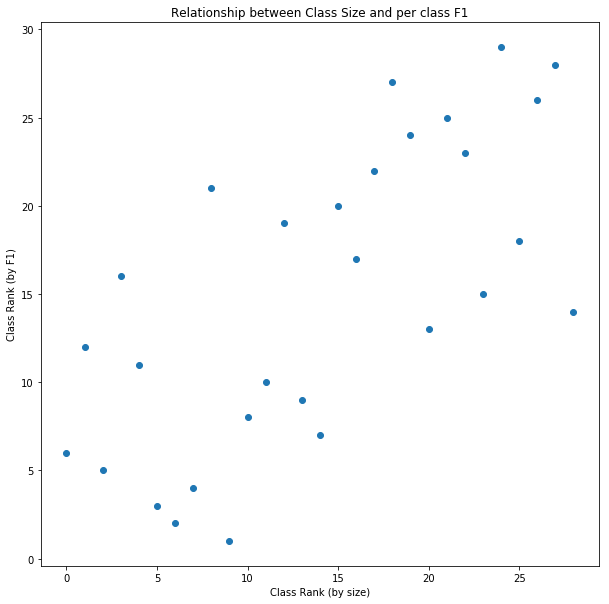

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(class_summary_tfidf.index, class_summary_tfidf['F1 Rank'])
plt.xlabel('Class Rank (by size)')
plt.ylabel('Class Rank (by F1)')
plt.title('Relationship between Class Size and per class F1')

Looking at the confusion matrix, we can definitely see patterns in the errors for the low performing classes. The biggest issue appears to be distinguishing between very similar classes rather than failing on strictly small sample classes. For example:
* Child & Adolescent Psychiatry getting mistaken for Psychiatry.
* Acute Care getting mistaken for Family.
* Primary Care getting mistaken for Family.
* Interventional Cardiology getting mistaken for Cardiovascular Disease.

In [ ]:
# Inspect the confustion matrix of predictions. The number in row i, column j is the count
# known to be in class i and predicted to be class j.
confusion_matrix_tfidf

,Cardiovascular Disease,Family,Psychiatry,Medical,Geriatric Medicine,Nephrology,Neurology,"Endocrinology, Diabetes & Metabolism",Adult Health,Rheumatology,Pulmonary Disease,Infectious Disease,Adult Medicine,Hematology & Oncology,Gastroenterology,Interventional Cardiology,Psych/Mental Health,Gerontology,Primary Care,Adolescent Medicine,Pain Medicine,Acute Care,Sports Medicine,Interventional Pain Medicine,Child & Adolescent Psychiatry,Addiction Medicine,Medical Oncology,Critical Care Medicine,Clinical Cardiac Electrophysiology
Cardiovascular Disease,3719,48,1,24,46,13,2,4,19,2,4,7,18,2,3,48,0,1,2,1,0,2,0,0,0,0,0,2,15
Family,55,2626,30,520,113,25,13,24,176,4,16,28,41,3,5,1,5,22,12,6,12,3,4,4,0,0,0,0,1
Psychiatry,2,12,2169,2,3,0,11,0,4,0,0,0,1,1,0,0,69,0,0,0,3,0,0,0,4,0,0,0,0
Medical,29,839,8,385,61,9,24,17,66,6,10,27,31,0,2,1,0,5,8,5,8,2,2,1,0,0,0,1,0
Geriatric Medicine,37,122,3,38,1004,17,0,9,48,3,21,7,68,5,8,0,0,46,1,8,0,0,2,0,0,0,0,0,0
Nephrology,16,22,0,9,24,1309,0,4,15,2,4,5,6,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
Neurology,1,12,22,17,5,0,1234,0,3,0,0,0,0,0,0,0,0,0,0,0,8,0,0,2,0,2,0,0,0
"Endocrinology, Diabetes & Metabolism",4,25,0,14,19,2,0,960,7,0,0,0,10,0,0,0,0,0,0,3,0,1,0,0,0,1,0,0,0
Adult Health,40,344,7,64,64,9,7,13,76,1,8,21,15,4,6,0,1,15,7,0,0,1,3,1,0,0,0,1,1
Rheumatology,3,11,0,12,7,2,0,0,1,598,2,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### LDA Features

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

def fit_lr_model(X_train, y_train, param_grid):
    # Define the logistic regression model
    lr = LogisticRegression(solver='lbfgs', max_iter=1000)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(lr, param_grid, cv=5)
    grid_search.fit(X_train_lda, y_train)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Make cross-validated predictions
    cv_preds = grid_search.predict(X_train_lda)

    # Generate classification report and confusion matrix
    class_summary = classification_report(y_train, cv_preds)
    conf_matrix = confusion_matrix(y_train, cv_preds)

    return best_model, cv_preds, class_summary, conf_matrix

# Example usage
param_grid = {'C': [10000000]}
ldalr_model, cv_preds_lda, class_summary_lda, confusion_matrix_lda = fit_lr_model(
    X_train_lda, provider_variables_train.specialty, param_grid)

print("Classification Summary:\n", class_summary_lda)
print("Confusion Matrix:\n", confusion_matrix_lda)


NameError: name 'X_train_lda' is not defined

In [ ]:
# Train a logistic regression model on LDA features. With such a comparatively low number of
# features, regularization really shouldn't be necessary here.
ldalr_model, cv_preds_lda, class_summary_lda, confusion_matrix_lda = fit_lr_model(
    X_train_lda, provider_variables_train.specialty, param_grid={'C': [10000000]})

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

/opt/conda/lib/python3.6/site-packages/s

In [ ]:
ldalr_model

NameError: name 'ldalr_model' is not defined

In [ ]:
ldalr_model.cv_results_

{'mean_fit_time': array([4.90449405]),
 'std_fit_time': array([0.11084352]),
 'mean_score_time': array([0.10690284]),
 'std_score_time': array([0.00130451]),
 'param_C': masked_array(data=[10000000],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 10000000}],
 'split0_test_f1_macro': array([0.37944211]),
 'split1_test_f1_macro': array([0.38735677]),
 'split2_test_f1_macro': array([0.37806381]),
 'mean_test_f1_macro': array([0.38162209]),
 'std_test_f1_macro': array([0.0040943]),
 'rank_test_f1_macro': array([1], dtype=int32),
 'split0_train_f1_macro': array([0.39754217]),
 'split1_train_f1_macro': array([0.3939948]),
 'split2_train_f1_macro': array([0.38054479]),
 'mean_train_f1_macro': array([0.39069392]),
 'std_train_f1_macro': array([0.00732118]),
 'split0_test_f1_micro': array([0.7296322]),
 'split1_test_f1_micro': array([0.73755908]),
 'split2_test_f1_micro': array([0.73607242]),
 'mean_test_f1_micro': array([0.73441772]),
 'std_te

In [ ]:
# Summary of F1 scores across classes on the cross validated predictions.
class_summary_lda

NameError: name 'class_summary_lda' is not defined

In [ ]:
# Inspect the confustion matrix of predictions. The number in row i, column j is the count
# known to be in class i and predicted to be class j.
confusion_matrix_lda

,Cardiovascular Disease,Family,Psychiatry,Medical,Geriatric Medicine,Nephrology,Neurology,"Endocrinology, Diabetes & Metabolism",Adult Health,Rheumatology,Pulmonary Disease,Infectious Disease,Adult Medicine,Hematology & Oncology,Gastroenterology,Interventional Cardiology,Psych/Mental Health,Gerontology,Primary Care,Adolescent Medicine,Pain Medicine,Acute Care,Sports Medicine,Interventional Pain Medicine,Child & Adolescent Psychiatry,Addiction Medicine,Medical Oncology,Critical Care Medicine,Clinical Cardiac Electrophysiology
Cardiovascular Disease,3819,64,0,10,65,6,1,1,1,0,3,3,8,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Family,70,3189,33,75,207,17,14,39,11,5,11,36,11,0,5,0,0,8,0,0,16,0,0,2,0,0,0,0,0
Psychiatry,0,9,2255,2,6,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
Medical,46,1202,9,82,88,6,24,18,3,5,5,26,16,0,2,0,0,3,0,0,12,0,0,0,0,0,0,0,0
Geriatric Medicine,43,253,2,19,1089,3,0,3,7,0,9,1,10,1,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0
Nephrology,19,53,0,3,35,1299,0,3,3,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Neurology,0,8,26,2,5,0,1255,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0
"Endocrinology, Diabetes & Metabolism",5,54,0,7,22,1,1,951,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Adult Health,46,424,9,16,123,13,6,14,6,2,7,24,3,2,3,0,0,8,0,0,2,0,0,1,0,0,0,0,0
Rheumatology,5,22,0,8,6,0,0,0,0,590,0,2,2,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
import pickle

# Assuming ldalr_model is your trained model
# Example: ldalr_model = your_trained_model

# Specify the filename
filename = 'ldalr_model.pkl'

# Open the file in write-binary mode and use pickle to dump the model
with open(filename, 'wb') as file:
    pickle.dump(ldalr_model, file)

print(f"Model saved to {filename}")


Model saved to ldalr_model.pkl
